# Импортируем нужные библиотеки

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms

import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image

%matplotlib inline

# Создадим DataLoader с нашим набором данных

In [8]:
data_dir = os.path.join(os.path.abspath(os.curdir), "dataset\\")

создадим словарь, содержащий трансформации для обучающей и тестовой выборок.

In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(66),
        #transforms.ColorJitter(brightness=0.5),
        #transforms.RandomRotation(15),
        #transforms.RandomPerspective(p=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize(66),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

In [20]:
def get_dataset(data_dir, data_transforms):
    """
    Функция для создания датасета
    
    Принимает на вход:
        -data_dir: str, директория с набором данных, разделенным на обучающую и тестовую выборку
        -data_transforms: dict, словарь с трансформациями изображений.
    Возвращает:
        -torch.utils.dataloader с набором данных для обучения модели
        -torch.utils.dataloader с набором данных для тестовой модели
        -classes, список распознаваемых классов
        -dataset_sizes, словарь с информацией о размере обучающей и тестовой выборках
    """

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

In [21]:
trainloader, testloader, classes, dataset_sizes = get_dataset(data_dir, data_transforms)
print('Классы: ',  classes)
print('Размер датасета: ',  dataset_sizes)

Классы:  ['no_mask', 'on_mask']
Размер датасета:  {'train': 1203, 'test': 296}


# Посмотрим на содержимое датасета

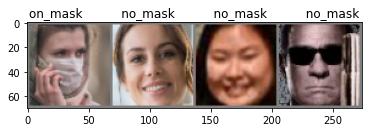

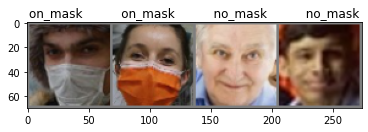

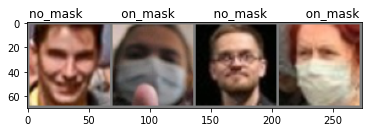

In [22]:
def imshow(img):
    """
    Функция для отображения изображения
    """
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def imshow_images_grid(rows=1):
    """
    Функция для отображения матрицы изображений размером batch_size x rows
    """
    dataiter = iter(trainloader)
    for _ in range(rows):
        
        img, labels = next(dataiter)
        img = torchvision.utils.make_grid(img)
        img = img / 2 + 0.5
        
        plt.title('          '.join('%5s' % classes[labels[j]] for j in range(4)))
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.show()
    
    
imshow_images_grid(3)

# Напишем нейронную сеть

In [13]:
class Softmax_layer(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        e = torch.exp(x - x.max(1, True)[0] )
        summ = e.sum(1, True)[0]
        return e / summ
    
class Flatten(torch.nn.Module):
    def forward(self, x):
        N = x.shape[0]
        return x.view(N, -1)

In [36]:
pretrained_model = models.resnet18(pretrained=True)
pretrained_model.fc = nn.Linear(512, 2)

In [37]:
conv_net = torch.nn.Sequential(torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
                               torch.nn.LeakyReLU(),
                               torch.nn.BatchNorm2d(32),
#                                torch.nn.Dropout2d(0.3),
                               
                               torch.nn.Conv2d(32, 64, 3, stride=2, padding=1),
                               torch.nn.LeakyReLU(),
                               torch.nn.BatchNorm2d(64),
#                                torch.nn.Dropout2d(0.3),
                               
#                                torch.nn.MaxPool2d(3, 2, 1),
                               
                               torch.nn.Conv2d(64, 128, 3, stride=2, padding=1),
                               torch.nn.LeakyReLU(),
                               torch.nn.BatchNorm2d(128),

                               
                               torch.nn.Conv2d(128, 256, 3, stride=2, padding=1),
                               torch.nn.LeakyReLU(),
                               torch.nn.BatchNorm2d(256),

                               
                               torch.nn.Conv2d(256, 512, 3, stride=2, padding=1),
                               torch.nn.LeakyReLU(),
#                                torch.nn.BatchNorm2d(512),
                               
                               
                               Flatten(),
                               torch.nn.Linear(4608, 2),
                               Softmax_layer()\
                              )

In [38]:
class NNClassifier(nn.Module):
    
    def __init__(self, model, trained_weights=None):
        super(NNClassifier, self).__init__()
        self.model = model
        
        if trained_weights is not None: 
            self.load_state_dict(torch.load(trained_weights))

    
    def fit(self, train_loader, epochs, lr):
        """
        Метод для обучения нейронной сети
        """
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        device = torch.device("cpu")
        for epoch in range(1, epochs+1):
            running_loss = 0
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            print(f"эпоха №{epoch}| ошибка: {loss}")
        print("Обучение завершено!")
        
    def test(self, test_loader):
        """
        Метод для тестирования нейронной сети
        """
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)

                for printdata in list(zip(predicted, labels, outputs)):
                    printclass = [classes[int(printdata[0])], classes[int(printdata[1])]]
                    print(f'Predict class - {printdata[0]}, real class - {printdata[1]}, {printdata[2]}')

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                imshow(torchvision.utils.make_grid(images))
                print("-----------------------------")

        print(f'Точность модели на {dataset_sizes["test"]} изображениях: {round(100 * correct / total, 5)}')
    
    def predict(self, frame):
        """
        Метод для получения предсказания нейронной сети
        """
        self.eval()

        frame = np.expand_dims(frame, 0)
        frame = torch.FloatTensor(frame)

        with torch.no_grad():
            probs = self.model(frame)

        return probs
    
    def save(self, PATH):
        """
        Метод для сохранения модели в формате .pt
        """
        torch.save(self.state_dict(), PATH)

In [39]:
mask_detector = NNClassifier(pretrained_model)

Обучим и протестируем модель.

In [40]:
mask_detector.fit(trainloader, 40, 5e-3)

эпоха №1| ошибка: 0.12128641456365585
эпоха №2| ошибка: 0.1338784545660019
эпоха №3| ошибка: 0.016768502071499825


KeyboardInterrupt: 

Predict class - 1, real class - 0, tensor([-1.7702,  1.7973])
Predict class - 0, real class - 0, tensor([ 1.7824, -1.4038])
Predict class - 0, real class - 0, tensor([ 1.8186, -1.3631])
Predict class - 0, real class - 0, tensor([ 0.9681, -0.9276])


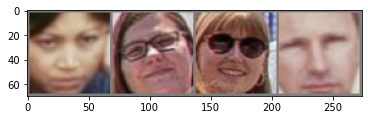

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.2282, -1.1050])
Predict class - 0, real class - 0, tensor([ 1.1542, -0.9547])
Predict class - 0, real class - 0, tensor([ 2.0004, -1.4278])
Predict class - 1, real class - 1, tensor([-4.6282,  4.4761])


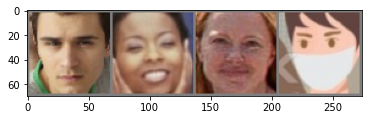

-----------------------------
Predict class - 1, real class - 1, tensor([-3.3695,  3.3617])
Predict class - 0, real class - 0, tensor([ 1.8038, -1.5056])
Predict class - 0, real class - 0, tensor([ 1.9980, -1.4921])
Predict class - 1, real class - 1, tensor([-2.8772,  2.8462])


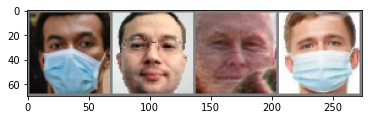

-----------------------------
Predict class - 1, real class - 1, tensor([-2.0696,  2.1208])
Predict class - 1, real class - 1, tensor([-2.6288,  2.5724])
Predict class - 0, real class - 0, tensor([ 1.9628, -1.4031])
Predict class - 1, real class - 1, tensor([-2.6529,  2.7666])


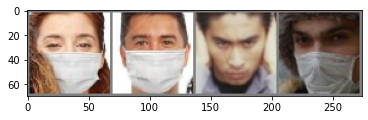

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.9340, -1.4400])
Predict class - 0, real class - 0, tensor([ 1.8635, -1.5103])
Predict class - 1, real class - 1, tensor([-2.7673,  2.7127])
Predict class - 1, real class - 1, tensor([-2.0580,  2.1092])


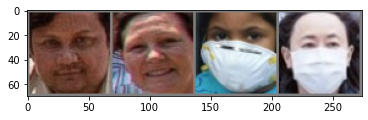

-----------------------------
Predict class - 1, real class - 1, tensor([-2.6053,  2.6108])
Predict class - 0, real class - 0, tensor([ 2.1506, -1.5421])
Predict class - 1, real class - 1, tensor([-2.2200,  2.2324])
Predict class - 1, real class - 1, tensor([-1.7254,  1.7487])


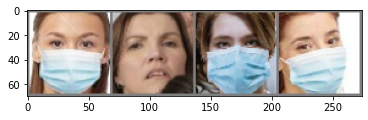

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.1307, -1.1018])
Predict class - 0, real class - 0, tensor([ 1.3814, -1.1231])
Predict class - 0, real class - 0, tensor([0.1116, 0.0594])
Predict class - 0, real class - 0, tensor([ 1.9091, -1.4403])


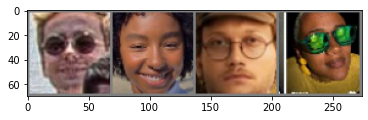

-----------------------------
Predict class - 0, real class - 0, tensor([ 2.0386, -1.5194])
Predict class - 0, real class - 0, tensor([ 1.1782, -1.0428])
Predict class - 0, real class - 0, tensor([ 1.3236, -1.0801])
Predict class - 1, real class - 1, tensor([-4.5652,  4.4418])


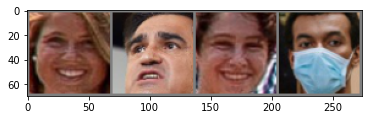

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.9721, -1.6154])
Predict class - 0, real class - 0, tensor([ 0.1983, -0.1136])
Predict class - 0, real class - 0, tensor([ 1.6131, -1.1752])
Predict class - 1, real class - 0, tensor([-1.4296,  1.4108])


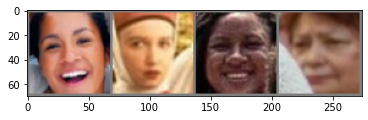

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.8460, -1.3762])
Predict class - 0, real class - 0, tensor([ 1.4115, -1.0543])
Predict class - 1, real class - 0, tensor([-0.7605,  0.7900])
Predict class - 0, real class - 0, tensor([ 0.9693, -0.9153])


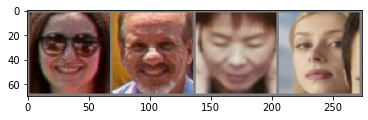

-----------------------------
Predict class - 0, real class - 0, tensor([ 2.2505, -1.6378])
Predict class - 0, real class - 0, tensor([ 0.8247, -0.7363])
Predict class - 1, real class - 1, tensor([-3.2746,  3.2886])
Predict class - 1, real class - 1, tensor([-2.8489,  2.8030])


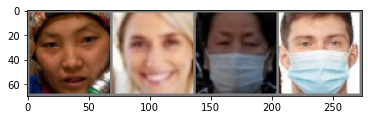

-----------------------------
Predict class - 1, real class - 1, tensor([-3.3167,  3.2640])
Predict class - 1, real class - 0, tensor([-1.0901,  1.1483])
Predict class - 0, real class - 0, tensor([ 2.7435, -2.0831])
Predict class - 1, real class - 1, tensor([-2.6156,  2.6055])


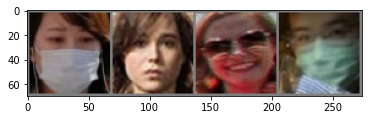

-----------------------------
Predict class - 1, real class - 1, tensor([-1.7070,  1.7379])
Predict class - 1, real class - 1, tensor([-2.4848,  2.4431])
Predict class - 0, real class - 0, tensor([ 2.2494, -1.6414])
Predict class - 1, real class - 1, tensor([-1.9155,  1.9775])


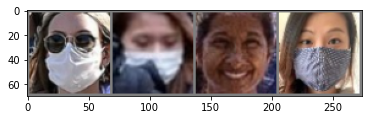

-----------------------------
Predict class - 0, real class - 0, tensor([ 0.8670, -0.7089])
Predict class - 0, real class - 0, tensor([ 0.7700, -0.6863])
Predict class - 1, real class - 0, tensor([-0.1590,  0.2150])
Predict class - 0, real class - 0, tensor([ 2.0235, -1.4319])


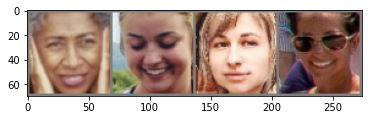

-----------------------------
Predict class - 0, real class - 0, tensor([ 2.0564, -1.5087])
Predict class - 1, real class - 1, tensor([-3.2252,  3.1836])
Predict class - 1, real class - 1, tensor([-2.8295,  2.8568])
Predict class - 0, real class - 0, tensor([ 1.5886, -1.3598])


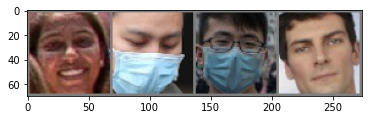

-----------------------------
Predict class - 0, real class - 0, tensor([ 0.5592, -0.5453])
Predict class - 0, real class - 0, tensor([ 1.8676, -1.4738])
Predict class - 0, real class - 0, tensor([ 1.4704, -0.9998])
Predict class - 1, real class - 0, tensor([-1.1882,  1.1605])


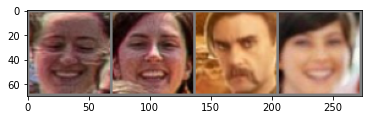

-----------------------------
Predict class - 1, real class - 1, tensor([-3.6796,  3.6626])
Predict class - 0, real class - 0, tensor([ 1.9846, -1.5578])
Predict class - 1, real class - 1, tensor([-2.3159,  2.3083])
Predict class - 0, real class - 0, tensor([ 1.9715, -1.5491])


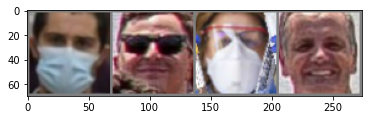

-----------------------------
Predict class - 0, real class - 0, tensor([ 2.1874, -1.5652])
Predict class - 1, real class - 1, tensor([-0.9672,  1.0850])
Predict class - 1, real class - 1, tensor([-2.9633,  2.9201])
Predict class - 1, real class - 1, tensor([-2.6083,  2.5758])


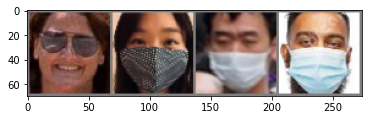

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.2172, -0.9133])
Predict class - 0, real class - 0, tensor([ 0.7227, -0.6585])
Predict class - 0, real class - 0, tensor([ 0.7603, -0.7080])
Predict class - 0, real class - 0, tensor([ 1.5635, -1.0835])


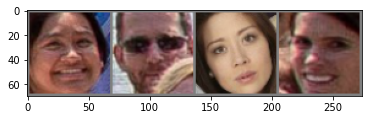

-----------------------------
Predict class - 1, real class - 1, tensor([-2.9108,  2.9176])
Predict class - 0, real class - 0, tensor([ 2.4787, -1.8710])
Predict class - 1, real class - 1, tensor([-2.1864,  2.1687])
Predict class - 1, real class - 1, tensor([-1.3353,  1.4080])


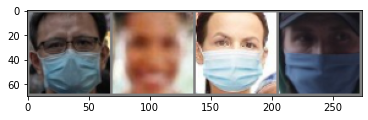

-----------------------------
Predict class - 1, real class - 0, tensor([-0.5330,  0.6105])
Predict class - 1, real class - 1, tensor([-2.7403,  2.7469])
Predict class - 1, real class - 1, tensor([-2.6257,  2.5907])
Predict class - 0, real class - 0, tensor([ 1.9089, -1.2988])


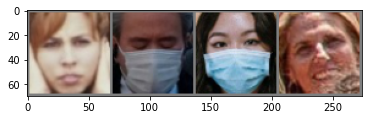

-----------------------------
Predict class - 1, real class - 1, tensor([-2.4895,  2.4329])
Predict class - 0, real class - 0, tensor([ 2.1769, -1.6335])
Predict class - 1, real class - 1, tensor([-3.1674,  3.1617])
Predict class - 0, real class - 0, tensor([ 1.4283, -1.1360])


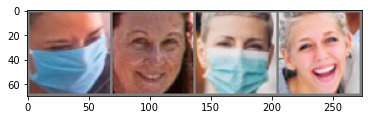

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.2438, -1.1700])
Predict class - 0, real class - 0, tensor([ 0.6976, -0.4895])
Predict class - 1, real class - 1, tensor([-1.4483,  1.4127])
Predict class - 0, real class - 0, tensor([ 1.9227, -1.3864])


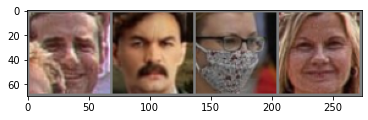

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.8243, -1.2838])
Predict class - 0, real class - 0, tensor([ 1.7407, -1.5220])
Predict class - 0, real class - 0, tensor([ 0.8294, -0.7310])
Predict class - 1, real class - 1, tensor([-5.2206,  5.0747])


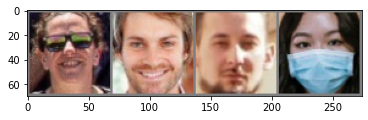

-----------------------------
Predict class - 1, real class - 1, tensor([-2.5984,  2.5611])
Predict class - 0, real class - 0, tensor([ 2.1584, -1.5449])
Predict class - 1, real class - 1, tensor([-2.1077,  2.1623])
Predict class - 1, real class - 1, tensor([-1.5311,  1.5455])


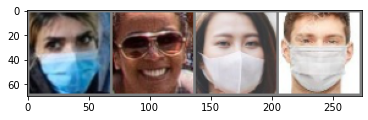

-----------------------------
Predict class - 0, real class - 0, tensor([ 0.8122, -0.7682])
Predict class - 1, real class - 1, tensor([-3.7635,  3.6728])
Predict class - 0, real class - 0, tensor([ 1.5442, -1.3216])
Predict class - 0, real class - 0, tensor([ 1.7694, -1.2248])


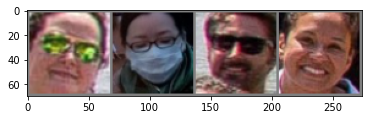

-----------------------------
Predict class - 1, real class - 1, tensor([-2.7155,  2.6679])
Predict class - 1, real class - 1, tensor([-2.4830,  2.4694])
Predict class - 1, real class - 0, tensor([-0.2513,  0.6862])
Predict class - 1, real class - 1, tensor([-1.1363,  1.4721])


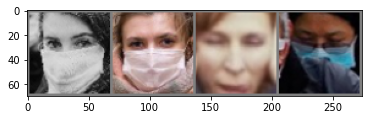

-----------------------------
Predict class - 0, real class - 0, tensor([ 2.0593, -1.5261])
Predict class - 1, real class - 1, tensor([-1.7543,  1.7872])
Predict class - 0, real class - 0, tensor([ 1.5512, -1.2892])
Predict class - 1, real class - 1, tensor([-3.1159,  3.0727])


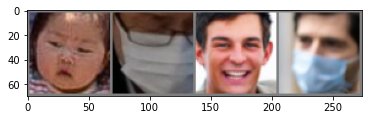

-----------------------------
Predict class - 0, real class - 0, tensor([ 0.8994, -0.8095])
Predict class - 0, real class - 0, tensor([ 2.0381, -1.4932])
Predict class - 0, real class - 0, tensor([ 1.7927, -1.5405])
Predict class - 1, real class - 1, tensor([-4.8981,  4.7563])


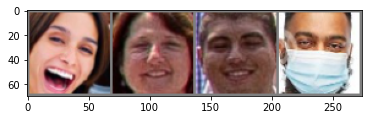

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.4943, -1.2757])
Predict class - 1, real class - 1, tensor([-3.6507,  3.5049])
Predict class - 0, real class - 0, tensor([ 1.8798, -1.4529])
Predict class - 0, real class - 0, tensor([ 1.6910, -1.3658])


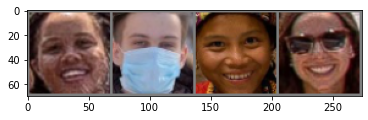

-----------------------------
Predict class - 1, real class - 1, tensor([-2.9044,  2.9572])
Predict class - 0, real class - 0, tensor([ 2.0864, -1.6489])
Predict class - 0, real class - 0, tensor([ 1.9063, -1.4916])
Predict class - 1, real class - 1, tensor([-2.6021,  2.5710])


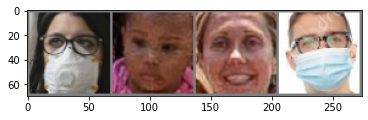

-----------------------------
Predict class - 0, real class - 0, tensor([ 2.1877, -1.6077])
Predict class - 1, real class - 1, tensor([-2.2901,  2.3677])
Predict class - 1, real class - 1, tensor([-2.6030,  2.5892])
Predict class - 1, real class - 1, tensor([-2.4479,  2.4775])


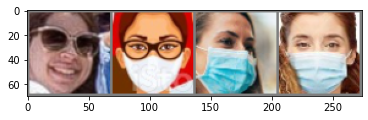

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.7182, -1.3335])
Predict class - 0, real class - 0, tensor([ 1.2041, -1.0997])
Predict class - 1, real class - 0, tensor([-2.2182,  2.1512])
Predict class - 0, real class - 0, tensor([ 1.7246, -1.2576])


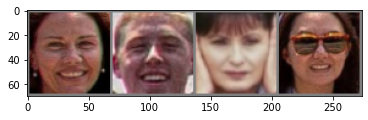

-----------------------------
Predict class - 1, real class - 1, tensor([-3.2169,  3.2028])
Predict class - 0, real class - 0, tensor([ 2.1073, -1.7199])
Predict class - 1, real class - 1, tensor([-2.8020,  2.7938])
Predict class - 0, real class - 0, tensor([ 1.9196, -1.4656])


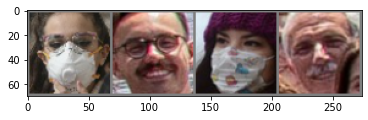

-----------------------------
Predict class - 1, real class - 1, tensor([-3.5996,  3.5992])
Predict class - 1, real class - 1, tensor([-2.4863,  2.4760])
Predict class - 0, real class - 0, tensor([ 1.7179, -1.2913])
Predict class - 0, real class - 0, tensor([ 1.9420, -1.5239])


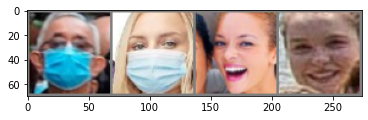

-----------------------------
Predict class - 1, real class - 1, tensor([-4.0817,  3.9396])
Predict class - 0, real class - 0, tensor([ 1.7636, -1.3530])
Predict class - 0, real class - 0, tensor([ 1.7856, -1.3610])
Predict class - 0, real class - 0, tensor([ 1.3915, -1.2626])


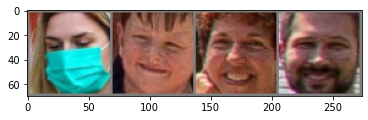

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.3125, -1.1721])
Predict class - 1, real class - 1, tensor([-3.3367,  3.3699])
Predict class - 0, real class - 0, tensor([ 2.1728, -1.5885])
Predict class - 1, real class - 1, tensor([-2.8390,  2.8313])


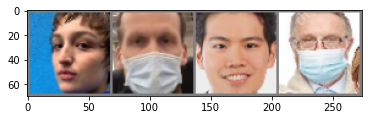

-----------------------------
Predict class - 0, real class - 0, tensor([ 0.6634, -0.6126])
Predict class - 0, real class - 0, tensor([ 2.4634, -1.8095])
Predict class - 1, real class - 1, tensor([-2.8838,  2.8520])
Predict class - 1, real class - 1, tensor([-3.2615,  3.2659])


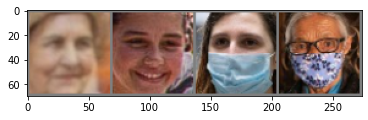

-----------------------------
Predict class - 1, real class - 1, tensor([-2.2886,  2.2923])
Predict class - 1, real class - 1, tensor([-1.3938,  1.4738])
Predict class - 1, real class - 1, tensor([-2.5851,  2.5515])
Predict class - 0, real class - 0, tensor([ 2.1506, -1.5342])


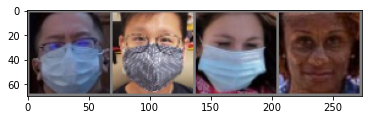

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.8879, -1.4169])
Predict class - 0, real class - 0, tensor([ 1.7286, -1.3651])
Predict class - 1, real class - 1, tensor([-3.8561,  3.7608])
Predict class - 0, real class - 0, tensor([ 1.2514, -1.1558])


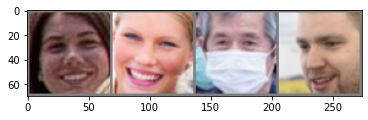

-----------------------------
Predict class - 1, real class - 0, tensor([-1.8866,  1.8205])
Predict class - 0, real class - 0, tensor([ 0.7513, -0.5537])
Predict class - 0, real class - 0, tensor([ 2.1748, -1.6716])
Predict class - 1, real class - 0, tensor([-0.4004,  0.5060])


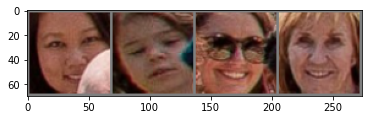

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.3852, -1.1046])
Predict class - 0, real class - 0, tensor([ 1.6913, -1.1837])
Predict class - 0, real class - 0, tensor([ 0.4236, -0.4601])
Predict class - 0, real class - 0, tensor([ 1.0186, -0.9427])


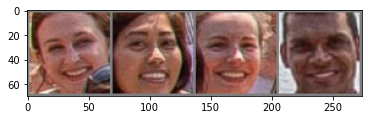

-----------------------------
Predict class - 0, real class - 0, tensor([ 0.8496, -0.7519])
Predict class - 0, real class - 0, tensor([ 1.4633, -0.9450])
Predict class - 1, real class - 1, tensor([-2.2597,  2.2766])
Predict class - 0, real class - 0, tensor([ 1.4620, -1.2870])


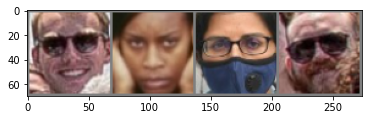

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.8089, -1.3472])
Predict class - 0, real class - 0, tensor([ 1.8618, -1.5160])
Predict class - 0, real class - 0, tensor([ 0.8073, -0.6840])
Predict class - 1, real class - 1, tensor([-4.1137,  3.9988])


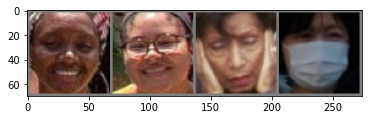

-----------------------------
Predict class - 1, real class - 1, tensor([-3.1441,  3.0973])
Predict class - 1, real class - 1, tensor([-2.7124,  2.7297])
Predict class - 0, real class - 0, tensor([ 1.8919, -1.4841])
Predict class - 0, real class - 0, tensor([ 2.0556, -1.6012])


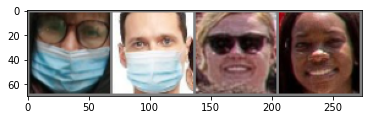

-----------------------------
Predict class - 1, real class - 1, tensor([-2.1339,  2.1247])
Predict class - 1, real class - 1, tensor([-2.2317,  2.2807])
Predict class - 0, real class - 0, tensor([ 2.1027, -1.5065])
Predict class - 1, real class - 1, tensor([-2.4809,  2.4963])


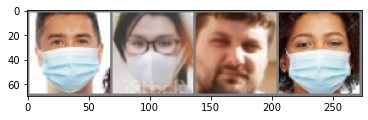

-----------------------------
Predict class - 0, real class - 0, tensor([ 0.7074, -0.5874])
Predict class - 1, real class - 1, tensor([-4.2262,  4.1756])
Predict class - 0, real class - 0, tensor([ 1.7185, -1.1556])
Predict class - 0, real class - 0, tensor([ 0.9857, -0.9387])


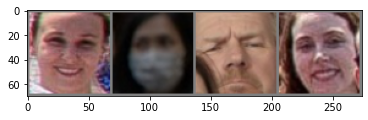

-----------------------------
Predict class - 0, real class - 1, tensor([ 1.9885, -1.5679])
Predict class - 0, real class - 0, tensor([ 1.5685, -1.1494])
Predict class - 1, real class - 1, tensor([-3.0802,  3.0403])
Predict class - 0, real class - 1, tensor([ 1.0584, -0.9781])


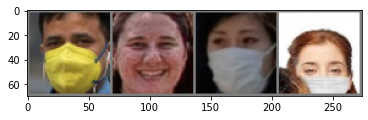

-----------------------------
Predict class - 0, real class - 0, tensor([ 2.0580, -1.5562])
Predict class - 1, real class - 1, tensor([-3.2807,  3.2593])
Predict class - 0, real class - 0, tensor([ 1.7505, -1.4055])
Predict class - 1, real class - 1, tensor([-2.6922,  2.6797])


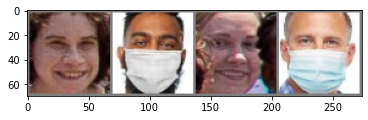

-----------------------------
Predict class - 0, real class - 0, tensor([ 0.4612, -0.5087])
Predict class - 0, real class - 0, tensor([ 1.4508, -1.0204])
Predict class - 0, real class - 0, tensor([ 1.0324, -0.8938])
Predict class - 0, real class - 1, tensor([ 1.7915, -1.4081])


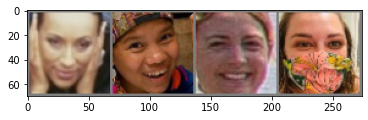

-----------------------------
Predict class - 1, real class - 1, tensor([-0.8913,  0.9277])
Predict class - 1, real class - 1, tensor([-2.2671,  2.3232])
Predict class - 0, real class - 0, tensor([ 2.2489, -1.6400])
Predict class - 1, real class - 1, tensor([-2.4745,  2.4787])


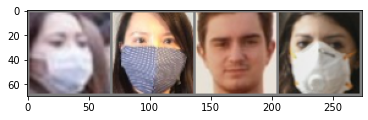

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.8667, -1.4552])
Predict class - 1, real class - 1, tensor([-2.7937,  2.8146])
Predict class - 1, real class - 1, tensor([-3.5566,  3.5090])
Predict class - 0, real class - 0, tensor([ 2.0156, -1.5847])


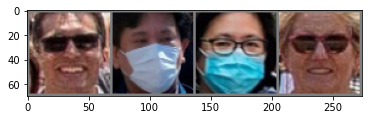

-----------------------------
Predict class - 1, real class - 1, tensor([-3.3750,  3.3769])
Predict class - 0, real class - 0, tensor([ 1.9707, -1.5984])
Predict class - 0, real class - 0, tensor([ 2.0241, -1.5624])
Predict class - 1, real class - 1, tensor([-2.4350,  2.4202])


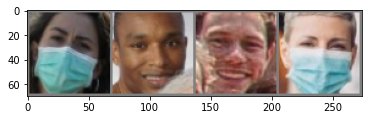

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.8764, -1.4153])
Predict class - 0, real class - 0, tensor([ 1.1307, -1.0041])
Predict class - 0, real class - 1, tensor([ 1.6573, -1.2893])
Predict class - 1, real class - 1, tensor([-4.0518,  3.9349])


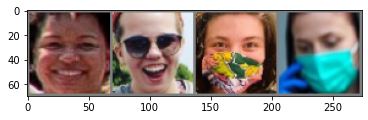

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.9001, -1.4560])
Predict class - 1, real class - 1, tensor([-0.1846,  0.2931])
Predict class - 0, real class - 0, tensor([ 1.8645, -1.4936])
Predict class - 1, real class - 1, tensor([-3.9717,  3.8657])


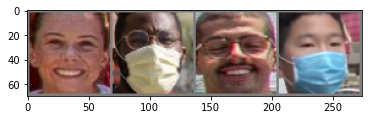

-----------------------------
Predict class - 0, real class - 0, tensor([ 0.6097, -0.5615])
Predict class - 0, real class - 0, tensor([ 2.4083, -1.7960])
Predict class - 1, real class - 1, tensor([-2.6981,  2.6736])
Predict class - 1, real class - 1, tensor([-3.1512,  3.2045])


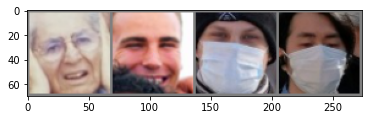

-----------------------------
Predict class - 1, real class - 1, tensor([-3.1324,  3.1156])
Predict class - 0, real class - 0, tensor([ 2.1705, -1.7186])
Predict class - 0, real class - 0, tensor([ 1.7626, -1.3633])
Predict class - 1, real class - 1, tensor([-2.0701,  2.0933])


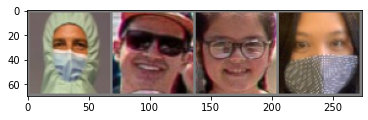

-----------------------------
Predict class - 0, real class - 0, tensor([ 2.1062, -1.6303])
Predict class - 0, real class - 0, tensor([ 1.7929, -1.4137])
Predict class - 1, real class - 1, tensor([-3.0996,  3.1119])
Predict class - 1, real class - 1, tensor([-2.9000,  2.8846])


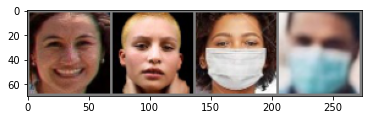

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.7793, -1.2307])
Predict class - 1, real class - 1, tensor([-4.9773,  4.8446])
Predict class - 0, real class - 0, tensor([ 1.2758, -1.0920])
Predict class - 0, real class - 0, tensor([ 1.2079, -1.0598])


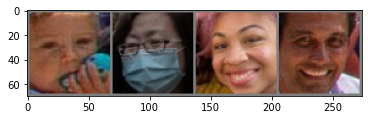

-----------------------------
Predict class - 1, real class - 0, tensor([-0.2918,  0.4130])
Predict class - 1, real class - 1, tensor([-3.5108,  3.4319])
Predict class - 0, real class - 0, tensor([ 1.9511, -1.5276])
Predict class - 0, real class - 0, tensor([ 1.9095, -1.5140])


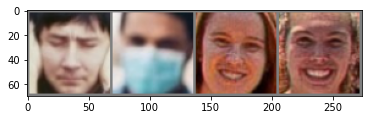

-----------------------------
Predict class - 1, real class - 1, tensor([-2.4632,  2.4355])
Predict class - 1, real class - 1, tensor([-3.4016,  3.4257])
Predict class - 0, real class - 0, tensor([ 1.9887, -1.5887])
Predict class - 0, real class - 0, tensor([ 1.8792, -1.4439])


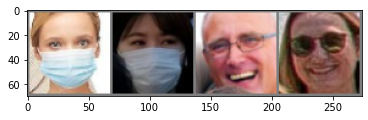

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.9007, -1.4150])
Predict class - 1, real class - 1, tensor([-4.1051,  3.9854])
Predict class - 0, real class - 0, tensor([ 1.3240, -1.1850])
Predict class - 0, real class - 0, tensor([ 1.6781, -1.3447])


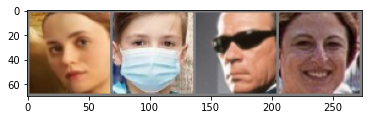

-----------------------------
Predict class - 1, real class - 1, tensor([-1.9111,  1.9167])
Predict class - 1, real class - 1, tensor([-2.2559,  2.2609])
Predict class - 1, real class - 1, tensor([-2.5420,  2.5929])
Predict class - 0, real class - 0, tensor([ 2.0922, -1.4913])


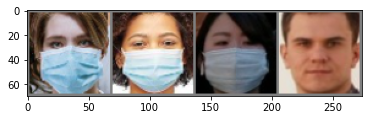

-----------------------------
Predict class - 0, real class - 0, tensor([ 0.8268, -0.7403])
Predict class - 0, real class - 0, tensor([ 0.3943, -0.3711])
Predict class - 0, real class - 0, tensor([ 2.1374, -1.4991])
Predict class - 1, real class - 1, tensor([-4.6245,  4.4824])


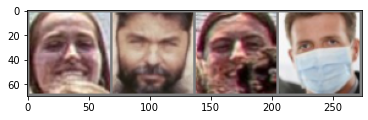

-----------------------------
Predict class - 0, real class - 1, tensor([ 1.3924, -1.0425])
Predict class - 1, real class - 1, tensor([-2.4264,  2.4087])
Predict class - 1, real class - 1, tensor([-3.2871,  3.2934])
Predict class - 0, real class - 0, tensor([ 2.3034, -1.8202])


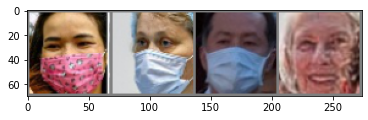

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.9405, -1.3118])
Predict class - 1, real class - 1, tensor([-4.3735,  4.2785])
Predict class - 0, real class - 0, tensor([ 0.8302, -0.6995])
Predict class - 0, real class - 0, tensor([ 0.2231, -0.2081])


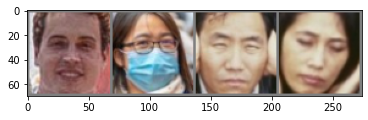

-----------------------------
Predict class - 1, real class - 1, tensor([-3.2978,  3.3003])
Predict class - 0, real class - 0, tensor([ 1.7567, -1.4048])
Predict class - 0, real class - 0, tensor([ 1.9871, -1.4989])
Predict class - 1, real class - 1, tensor([-2.5400,  2.5185])


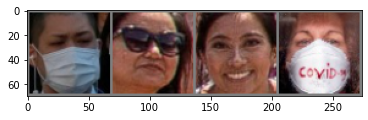

-----------------------------
Predict class - 1, real class - 1, tensor([-3.5894,  3.5933])
Predict class - 0, real class - 0, tensor([ 1.9408, -1.5179])
Predict class - 0, real class - 0, tensor([ 2.0161, -1.5883])
Predict class - 1, real class - 1, tensor([-1.8510,  1.8518])


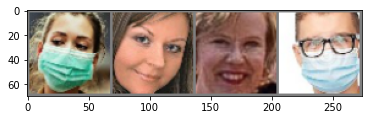

-----------------------------
Predict class - 0, real class - 0, tensor([ 0.8763, -0.7530])
Predict class - 1, real class - 1, tensor([-4.7546,  4.6105])
Predict class - 0, real class - 0, tensor([ 1.8452, -1.2430])
Predict class - 0, real class - 0, tensor([ 0.9850, -0.9144])


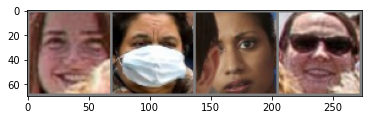

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.9155, -1.5082])
Predict class - 0, real class - 0, tensor([ 1.2441, -1.0749])
Predict class - 0, real class - 0, tensor([ 1.9200, -1.5213])
Predict class - 1, real class - 1, tensor([-3.8794,  3.8050])


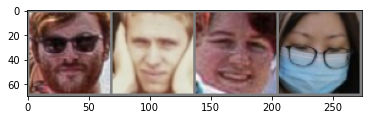

-----------------------------
Predict class - 0, real class - 0, tensor([ 1.1881, -0.8185])
Predict class - 0, real class - 0, tensor([ 0.8904, -0.8708])
Predict class - 0, real class - 0, tensor([ 1.0013, -0.8967])
Predict class - 0, real class - 0, tensor([ 1.6985, -1.2834])


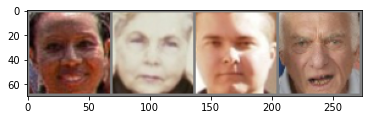

-----------------------------
Predict class - 1, real class - 1, tensor([-2.0755,  2.1660])
Predict class - 1, real class - 1, tensor([-0.5054,  0.5182])
Predict class - 0, real class - 0, tensor([ 2.0864, -1.4728])
Predict class - 1, real class - 1, tensor([-2.8683,  2.8465])


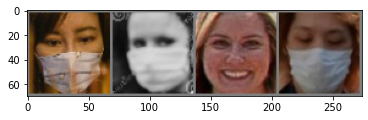

-----------------------------
Predict class - 1, real class - 1, tensor([-3.1316,  3.0741])
Predict class - 0, real class - 0, tensor([ 2.0345, -1.6700])
Predict class - 0, real class - 0, tensor([ 1.9774, -1.5145])
Predict class - 1, real class - 1, tensor([-1.8349,  1.8897])


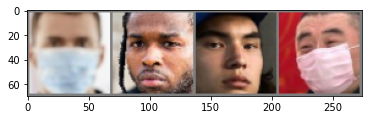

-----------------------------
Predict class - 0, real class - 0, tensor([ 2.1837, -1.5593])
Predict class - 0, real class - 1, tensor([ 0.8049, -0.6984])
Predict class - 1, real class - 0, tensor([-0.0818,  0.0933])
Predict class - 1, real class - 1, tensor([-3.0659,  3.0329])


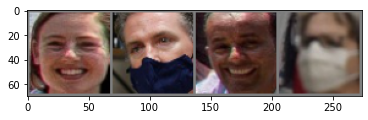

-----------------------------
Точность модели на 296 изображениях: 93.58108


In [41]:
mask_detector.test(testloader)

Сохраним результат

In [42]:
mask_detector.save("trained_weights.pt")

Проверим, сохранились ли веса нейронной сети

In [ ]:
test_model = NNClassifier(conv_net, "trained_weights.pt")

In [ ]:
test_model.test(testloader)

Проверим работу модели на конкретном изображении

In [112]:
img = cv2.imread("dataset//test//on_mask//img1072.jpg")
img = cv2.resize(img, (32, 32))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.transpose(img, (2, 1, 0))
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img = torch.FloatTensor(img)

In [113]:
img1 = cv2.imread("dataset//test//no_mask//img883.jpg")
img1 = cv2.resize(img1, (32, 32))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1 = np.transpose(img1, (2, 1, 0))
img1 = cv2.normalize(img1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img1 = torch.FloatTensor(img1)

In [114]:
test_model.predict(img)

tensor([[0.3374, 0.6626]])

In [115]:
test_model.predict(img1)

tensor([[0.9785, 0.0215]])

In [118]:
img1.size()

torch.Size([3, 32, 32])